In [1]:
# Import python modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import pprint
import sys

#import linkage_tools
from linkage_tools import *
from Probabilistic import *
from Perceptron import *

'''
from NeuralNetwork import *
'''

l = Linker()

#import warnings
#warnings.filterwarnings('error')

### Define functions

In [2]:
"""
def prob_link(row,features):
    ''' Get linkage score for each row of cross-joined blocks (pandas dataframe) '''
    return np.sum(
    [np.log(m_probs[key]/u_probs[key]) if row[key] else np.log((1-m_probs[key])/(1-u_probs[key]))
                                                                             for key in features])
"""

def prec_recall(linkage_score,theta,true_matches):
    ''' 
    Get precision and recall from linkage data
    - Precision: the percent of pairs with a score above theta that are real matches
    - Recall: the percent of known matched pairs that get a score above theta
    '''
    precision = []
    recall = []

    for cutoff in theta:
        winners = (linkage_score>cutoff)
        #winners = (big_bool['linkage_score']>cutoff)&bool_table['pair_match']
        
        # - numerator: number of NOMINATED pairs with a score above theta that are real matches
        real_picks = sum(winners&true_matches)
        # - denominater: number of NOMINATED pairs with a score above theta
        picks = sum(winners)
        precision.append(real_picks/float(picks)*100)

        # - numerator: number of NOMINATED pairs with a score above theta that are real matches
        # - denominater: number of pairs that are real matches
        real_matches = true_matches.sum()
        recall.append(real_picks/float(real_matches)*100)
        
    return precision,recall

### Define tables

In [3]:
tableA = '''patient_discharges JOIN newborns
ON patient_discharges.id = newborns.patient_discharge_id
LEFT OUTER JOIN patient_payers AS newborn_payers
ON newborn_payers.patient_discharge_id = patient_discharges.id'''

tableB = '''births JOIN deliveries 
ON births.delivery_id = deliveries.id
JOIN patient_discharges AS delivery_discharges
ON deliveries.patient_discharge_id = delivery_discharges.id
LEFT OUTER JOIN patient_payers AS delivery_payers
ON delivery_payers.patient_discharge_id = delivery_discharges.id'''

### Define linking variables

In [4]:
# Define fields to compare tables by
tableA_fields = ['patient_discharges.sex_id','newborns.id','newborns.cesarean_section', 
            'patient_discharges.zip_code','patient_discharges.race_id','patient_discharges.ethnicity_id', 
                'newborn_payers.payer_type_of_coverage_id','patient_discharges.principal_language_spoken', 
                 'patient_discharges.discharged_on','newborn_payers.payer_category_id',
                 'newborn_payers.plan_code_number','newborns.birth_weight_group_id',
                 'newborns.gestational_age_group_id','newborns.plurality_group_id']

tableB_fields = ['births.sex_id','births.newborn_id','births.delivery_route_id', 
            'births.mothers_residence_zip_code','delivery_discharges.race_id','delivery_discharges.ethnicity_id', 
                'delivery_payers.payer_type_of_coverage_id','delivery_discharges.principal_language_spoken', 
                 'delivery_discharges.discharged_on','delivery_payers.payer_category_id',
                 'delivery_payers.plan_code_number','births.birth_weight',
                 'births.gestational_age_ob_estimate','births.plurality'] 

feature_vals = ['sex_id','c_section','zip_code','race','ethnicity','payer_type_of_coverage_id',
                'language_spoken','discharge','payer_category_id','plan_code_number','weight_group_id',
                'gest_age_group_id','weight_plus','weight_minus','plurality'] 

# Define bins to use for certain fields
age_bins = np.concatenate(([1,24], np.arange(25, 36, 2),[99]), axis=0)
bw_bins = np.concatenate(([1], np.arange(500, 2001, 250),[2500,9999]), axis=0)
    
# Define conditions (expressions) on which to compare fields
conditions = [  "cross_table['sex_id_x']==cross_table['sex_id_y']",
                "cross_table['cesarean_section']==cross_table['delivery_route_id']",
                "cross_table['zip_code']==cross_table['mothers_residence_zip_code']",
                "cross_table['race_id_x']==cross_table['race_id_y']",
                "cross_table['ethnicity_id_x']==cross_table['ethnicity_id_y']",
                "cross_table['payer_type_of_coverage_id_x']==cross_table['payer_type_of_coverage_id_y']",
                "cross_table['principal_language_spoken_x']==cross_table['principal_language_spoken_y']",
                "cross_table['discharged_on_x']==cross_table['discharged_on_y']",
                "cross_table['payer_category_id_x']==cross_table['payer_category_id_y']",
                "cross_table['plan_code_number_x']==cross_table['plan_code_number_y']",
                "cross_table['birth_weight_group_id']==np.digitize(list(cross_table['birth_weight']),bw_bins)",
                "cross_table['gestational_age_group_id']==np.digitize(list(cross_table['gestational_age_ob_estimate']/7),age_bins)+1",
                "cross_table['birth_weight_group_id']==np.digitize(list(cross_table['birth_weight']),bw_bins)+1",
                "cross_table['birth_weight_group_id']==np.digitize(list(cross_table['birth_weight']),bw_bins)-1",
                "cross_table['plurality_group_id']==cross_table['plurality']"   ] 

simple_features = feature_vals[0:12]
#complex_features = feature_vals[12:]

learning_rate = 0.01 # small, constant learning rate for perceptron

# Create instances of learners
pr_simple = Probabilistic(len(simple_features)) # probabilistic linkage (simple features only)
pr_complex = Probabilistic(len(conditions)) # probabilistic linkage (all features)

pt = Perceptron(len(conditions),learning_rate) # single-layer perceptron
# n = l.neuralNetwork(input_nodes,hidden_nodes,output_nodes,learning_rate) # multi-layer neural network

verbose = True

### Blocking

In [5]:
"""
# Find relative frequencies of values in each field
# - save each as dictionary (1 dict per field per table)
rel_freq_tA = {}

for i in tableA_fields:

    stmt = '''SELECT {0} value, COUNT(*) count
    FROM {1}
    GROUP BY {0};'''.format(i,tableA)

    field_dict = exec_statement(stmt,'dict')
    rel_freq_tA[i] = dict(zip(field_dict['value'],field_dict['count']))
    
rel_freq_tB = {}
for i in tableB_fields:

    stmt = '''SELECT {0} value, COUNT(*) count
    FROM {1}
    GROUP BY {0};'''.format(i,tableB)

    field_dict = exec_statement(stmt,'dict')
    rel_freq_tB[i] = dict(zip(field_dict['value'],field_dict['count']))
"""
    
# Find all possible values for 1st blocking field ('hospital_id')
stmt = '''
SELECT DISTINCT patient_discharges.hospital_id
FROM patient_discharges 
UNION
SELECT DISTINCT births.hospital_id
FROM births;'''
block_list1 = [x[0] for x in l.exec_sql(stmt).values.tolist()]

block_list1 = block_list1[0:2]

# Find all possible values for 2nd blocking field ('date_of_delivery')
stmt = '''
SELECT DISTINCT births.date_of_delivery
FROM births;'''
block_list2 = [x[0] for x in l.exec_sql(stmt).values.tolist()]

block_list2 = block_list2[500:599]

block_prod = [(str(x),str(y)) for x in block_list1 for y in block_list2]

### Iterate over each block
- Create each block and export to python pandas dataframe
- Cross join the features-of-interest from both blocks (dataframes)
- Other stuff...
- Maximize match score with Kuhn-Munkres (i.e. Hungarian) Algorithm [more info]

[more info]: https://pypi.python.org/pypi/munkres/

In [6]:
# tss_iter_list = []
prec_iter_list = []
recall_iter_list = []
iter_qual_list = []
duration = [] # for timer
prev_iter_qual = 0 # for breaking link-iteration loop
link_iter = 0
verb_str = '\r Iter. #{}, blockA: {} records, blockB: {} records  ' # verbose output

while True:

    big_bool = pd.DataFrame(columns=feature_vals)

    tss = 0.0 # total sum-squared error

    for block1, block2 in block_prod:
        
        start = time.time() # Measure loop iteration duration

        # Create 'blockA'
        stmt1 = '''
        SELECT patient_discharges.id AS pdd_id, newborns.id AS newb_id,%s 
        FROM %s
        WHERE patient_discharges.hospital_id = %r
        AND patient_discharges.date_of_birth = %r;
        ''' % (",".join(tableA_fields),tableA,block1,block2)
        blockA = l.exec_sql(stmt1)

        # Create 'blockB'
        stmt2 = '''
        SELECT births.id AS bc_id,%s
        FROM %s
        WHERE births.hospital_id = %r
        AND births.date_of_delivery = %r;
        ''' % (",".join(tableB_fields),tableB,block1,block2)
        blockB = l.exec_sql(stmt2)
        
        if verbose:
            # Print on each iteration
            sys.stdout.write(verb_str.format(link_iter+1, len(blockA), len(blockB)))
            sys.stdout.flush() 
        
        # Check that neither block is empty - If empty, skip to next record-pair iteration in loop
        if (len(blockA)==0) or (len(blockB)==0):
            continue

        # Cross-join both blocks
        cross_table = l.df_crossjoin(blockA, blockB)

        # Count field matches and dump each into new column of dataframe
        bool_table = pd.DataFrame.from_items(zip(feature_vals,[eval(x).values for x in conditions]))

        # Add record-id columns to boolean table
        bool_table['newb_id'] = cross_table['newb_id'].values # Actual newborn id
        bool_table['bc_id'] = cross_table['bc_id'].values  # Actual bc id

        # Compare with previously-linked newborn id
        bool_table['real_match'] = (cross_table['newborn_id']==cross_table['newb_id']).values 
        bool_table['pair_match'] = False # Create new column for later
        bool_table['pair_match_simple'] = False # Create new column for later

        # Get guesses
        links_ind,link_score = pr_simple.query(bool_table[simple_features],bool_table[['newb_id','bc_id']])
        bool_table['linkage_score_simple'] = link_score
        bool_table.loc[links_ind,'pair_match_simple'] = True
        
        links_ind,link_score = pr_complex.query(bool_table[feature_vals],bool_table[['newb_id','bc_id']])
        bool_table['linkage_score'] = link_score
        bool_table.loc[links_ind,'pair_match'] = True # Label nominees as such        

        links_ind_pt = pt.query(bool_table[feature_vals])
        bool_table.loc[links_ind_pt==True,'pair_match_perceptron'] = True # Label nominees as such        
        # Train perceptron immediately
        pt.train(bool_table[feature_vals],bool_table['pair_match'])
        
        # Aggregate field-match tables (Booleans) within loop
        big_bool = pd.concat([big_bool,bool_table])

        # Time duration of each iteration
        duration.append(time.time()-start)

    # Save dataframe to file    
    #big_bool.to_pickle('big_bool.pkl')
    
    # Train learners
    pr_complex.train(big_bool[feature_vals],big_bool['pair_match'])
    pr_simple.train(big_bool[simple_features],big_bool['pair_match_simple'])
    
    # Get range of linkage scores (0 through 100 percentiles) i.e. decision threshold (theta)
    theta = np.percentile(big_bool['linkage_score'].loc[big_bool['real_match']==True],range(0,100,10))
    precision,recall = prec_recall(big_bool['linkage_score'],theta,big_bool['real_match']) # Measure precision & recall
    prec_iter_list.append(precision)
    recall_iter_list.append(recall)
    #tss_iter_list.append(tss)

    cur_iter_qual = abs(np.nanmean(precision) + np.nanmean(recall))
    iter_qual_list.append(cur_iter_qual)

    # Compare current iteration with previous iterations
    if abs(cur_iter_qual-prev_iter_qual)<.01: # If not improving
        print str.format("\n'Quality' achieved! @ {}",cur_iter_qual)
        break # Break outer loop
    else:
        prev_iter_qual = cur_iter_qual # Update comparative value

    if verbose:
        #print '\n',pd.DataFrame([m_probs, u_probs, weights],index=['m_probs', 'u_probs', 'weights'])
        print str.format('\n Average block loop iteration duration: {0:.2f} seconds', sum(duration) / len(duration))
        if 'prev_iter_qual' in locals():
            print str.format(" 'Quality' of prev. iter.: {}", prev_iter_qual)

    link_iter += 1 # Increment while loop iterator
    

 Iter. #1, blockA: 4 records, blockB: 4 records    
 Average block loop iteration duration: 0.06 seconds
 'Quality' of prev. iter.: 89.9949000108
 Iter. #2, blockA: 4 records, blockB: 4 records    
 Average block loop iteration duration: 0.06 seconds
 'Quality' of prev. iter.: 102.173500114
 Iter. #3, blockA: 4 records, blockB: 4 records    
 Average block loop iteration duration: 0.06 seconds
 'Quality' of prev. iter.: 102.292913778
 Iter. #4, blockA: 4 records, blockB: 4 records    
'Quality' achieved! @ 102.292913778


In [43]:
inputs_list = bool_table[feature_vals]
predictions = pt.query(inputs_list)
targets = np.array(bool_table['pair_match'], ndmin=2)

inputs = np.array(inputs_list, ndmin=2)
inputs = np.concatenate((inputs,np.repeat(1, len(inputs[:,1]))[:, None]), axis=1) # Add bias input
weights = np.random.uniform(low=-0.01, high=0.01, size=len(inputs[1,:]))

print inputs.shape,weights.shape,output_errors.shape
    
output_errors = targets-predictions

print learning_rate * np.dot(output_errors, inputs)

for i,row in enumerate(inputs):
    foo = output_errors[:,i] * row
    weights += learning_rate * output_errors[:,i] * row
print weights

(60, 16) (16,) (1, 60)
[[ 0.06  0.    0.    0.    0.    0.    0.    0.05  0.    0.    0.    0.01
   0.    0.01  0.06  0.06]]
[ 0.05053299 -0.00439694 -0.00541998  0.00430123 -0.00652904 -0.00530118
 -0.00350109  0.04776294  0.00152901 -0.00795734 -0.00994249  0.00376842
 -0.00987465  0.01943433  0.06769791  0.06281034]


In [169]:
'''
foo_tss = 0
foo_activation_function = lambda x: (x>0)*1

# Convert inputs list to 2d array
inputs_foo = np.array(bool_table[feature_vals], ndmin=2).T
inputs_foo = np.vstack([inputs_foo,np.repeat(1, len(inputs_foo[1,:]))]) # Add bias input
targets = np.array(bool_table['pair_match'], ndmin=2)
weights_foo = np.random.uniform(low=-0.01, high=0.01, size=len(inputs_foo[:,1]))

# Calculate signals into perceptron
final_inputs = np.dot(weights_foo, inputs_foo)
# Calculate the perceptron predictions
final_outputs = foo_activation_function(final_inputs)
#print weights_foo,'\n',inputs_foo,'\n',final_inputs,'\n',final_outputs
'''
inputs_foo = np.array(bool_table[feature_vals], ndmin=2)
inputs_foo = np.concatenate((inputs_foo,np.repeat(1, len(inputs_foo[:,1]))[:, None]), axis=1) # Add bias input
weights_foo = np.random.uniform(low=-0.01, high=0.01, size=len(inputs_foo[:,1]))
#print inputs_foo.shape,weights_foo.shape

predictions = pt.query(bool_table[feature_vals])
targets = np.array(bool_table['pair_match'], ndmin=2)

output_errors = targets-predictions
foo_tss = sum(output_errors**2)
foo_mat =  inputs_foo * output_errors * learning_rate


inputs_foo[0,:] * output_errors[:,0] * learning_rate

for i,row in enumerate(inputs_foo):
    #weights_foo += learning_rate * output_errors[:,i] * row
    print row * output_errors[:,i] * learning_rate
#print foo_mat
print output_errors.shape,inputs_foo.shape, weights_foo.shape
# Output error (target - actual)
#print foo_outputs.shape,output_errors.shape,inputs_foo.shape
#print output_errors

#print learning_rate * np.dot(output_errors, inputs_foo)
'''
# Update the weights
weights_foo += learning_rate * np.dot(output_errors.T, inputs_foo)
'''

'''
m = np.array([[1,2,3],[4,5,6],[7,8,9]])
>>> c = np.array([0,1,2])
>>> m * c
array([[ 0,  2,  6],
       [ 0,  5, 12],
       [ 0,  8, 18]])
'''


[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -0.01 -0.01]
[ 0.01  0.    0.    0.    0.    0.    0.    0.01  0.    0.    0.    0.    0.
  0.    0.01  0.01]
[ 0.    0.    0.    0.    0.    0.    0.   -0.01  0.    0.    0.    0.    0.
  0.   -0.01 -0.01]
[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -0.01 -0.01]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.    0.    0.    0.    0.    0.    0.   -0.01  0.    0.    0.    0.    0.
  0.   -0.01 -0.01]
[ 0.01  0.    0.    0.    0.    0.    0.    0.01  0.    0.    0.    0.    0.
  0.    0.01  0.01]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.01
  0.    0.   -0.01 -0.01]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[-0.01 -0.01  0.    0.    0.    0.    0.    0.    0.   

'\nm = np.array([[1,2,3],[4,5,6],[7,8,9]])\n>>> c = np.array([0,1,2])\n>>> m * c\narray([[ 0,  2,  6],\n       [ 0,  5, 12],\n       [ 0,  8, 18]])\n'

In [167]:
print inputs_foo[0:3,:] * output_errors[0:3,0].T * learning_rate

for i,row in enumerate(inputs_foo[0:3,:]):
    weights_foo += learning_rate * output_errors[:,i] * row
    print row * output_errors[:,i] * learning_rate
    #print row

[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.   -0.01 -0.01]
 [-0.01  0.    0.    0.    0.    0.    0.   -0.01  0.    0.    0.    0.    0.
   0.   -0.01 -0.01]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.01  0.    0.    0.    0.    0.
   0.   -0.01 -0.01]]
[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -0.01 -0.01]
[ 0.01  0.    0.    0.    0.    0.    0.    0.01  0.    0.    0.    0.    0.
  0.    0.01  0.01]
[ 0.    0.    0.    0.    0.    0.    0.   -0.01  0.    0.    0.    0.    0.
  0.   -0.01 -0.01]


In [7]:
bool_table
#bool_table[feature_vals].apply(prob_link, axis=1, features=feature_vals[simple_features])
#complex_features
# bool_table[feature_vals[simple_features]].apply(prob_link, axis=1)

,c_section,discharge,ethnicity,gest_age_group_id,language_spoken,payer_category_id,payer_type_of_coverage_id,plan_code_number,race,sex_id,...,weight_minus,weight_plus,zip_code,newb_id,bc_id,real_match,pair_match,linkage_score,linkage_score_simple,linkage_cost
0,False,False,False,False,False,True,False,False,False,False,...,True,False,False,19440,41210,False,True,0.090536,-0.085081,0.017088
1,False,False,False,False,False,False,False,False,False,False,...,True,False,False,19440,41211,False,False,-0.113201,0.106381,0.220825
2,False,False,False,False,False,True,True,False,False,False,...,True,False,False,19440,41212,False,False,-0.047231,0.044385,0.154855
3,False,False,False,False,False,False,False,False,False,False,...,True,False,False,19440,41218,False,False,-0.113201,0.106381,0.220825
4,False,False,False,False,False,True,True,False,False,False,...,True,False,False,19440,41219,False,False,-0.047231,0.044385,0.154855
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,17789,41210,False,False,0.107624,0.106381,0.000000
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,17789,41211,False,False,0.107624,0.106381,0.000000
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,17789,41212,False,False,0.107624,0.106381,0.000000
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,17789,41218,False,False,0.107624,0.106381,0.000000
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,17789,41219,False,True,0.107624,0.106381,0.000000


### Plot precision/recall for each iteration of probabilistic record linkage

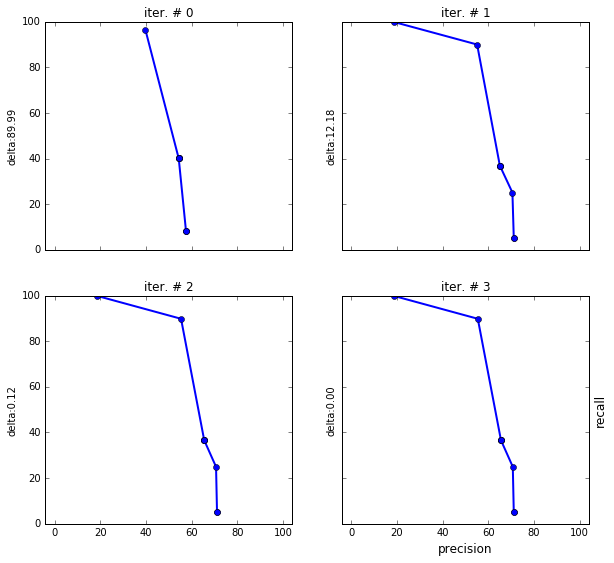

In [7]:
deltas = np.diff([0]+iter_qual_list)

# row and column sharing
ncol = int(np.ceil(np.sqrt(len(prec_iter_list))))
nrow = int(np.ceil(len(prec_iter_list)/float(ncol)))
fig, axs = plt.subplots(nrow, ncol, sharex='col', sharey='row')
for i, ax in enumerate(fig.axes[0:len(prec_iter_list)]):
    ax.set_xlim([0,100])
    ax.set_ylim([0,100])
    ax.plot(prec_iter_list[i], recall_iter_list[i], '-', linewidth=2, marker='o', color='b')
    ax.set_title("iter. # {}".format(str(i)), fontsize=12)
    ax.set_ylabel("delta:{0:3.2f}".format(float(deltas[i])), fontsize=10)
    ax.set(aspect='equal')    
else:
    ax.set_xlabel('precision', fontsize=12)
    ax2 = ax.twinx()
    plt.setp(ax2.get_yticklabels(), visible=False)
    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel('recall', fontsize=12)
    
fig.set_size_inches(4.875*ncol,4.5*nrow)
plt.show()

In [ ]:
print m_probs,u_probs

In [ ]:
bool_table = pd.DataFrame(columns=feature_vals)
for field, cond in zip(feature_vals, conditions):
    cond_res = eval(cond)
    bool_table[field] = cond_res.values
    
print(zip(feature_vals, conditions))

In [ ]:
big_bool

In [ ]:
cutoff = theta[-1]
winners = (big_bool['linkage_score']>cutoff)
print sum(winners&big_bool['real_match'])
print sum(winners&big_bool['pair_match']&big_bool['real_match'])
print sum(big_bool['pair_match']&big_bool['real_match'])

# Precision: the percent of pairs with a score above theta that are real matches
# USE ONLY NOMINATED PAIRS
# - numerator: number of NOMINATED pairs with a score above theta that are real matches
real_picks = sum(winners&big_bool['real_match']&big_bool['pair_match'])
# - denominater: number of NOMINATED pairs with a score above theta
picks = sum(winners&big_bool['pair_match'])
precision = (real_picks/float(picks)*100)

# Recall: the percent of known matched pairs that get a score above theta
# - numerator: number of NOMINATED pairs with a score above theta that are real matches
# - denominater: number of pairs that are real matches
real_matches = big_bool['real_match'].sum()
recall = (real_picks/float(real_matches)*100)

print precision,recall

In [ ]:

"""
[1,  '< 500g',          1,    1 ..  499, 1],
    [2,  '500 to 749g',     2,  500 ..  749, 1],
    [3,  '750 to 999g',     3,  750 ..  999, 1],
    [4,  '1,000 to 1,250g', 4, 1000 .. 1250, 2],
    [5,  '1,250 to 1,499g', 5, 1250 .. 1499, 2],
    [6,  '1,500 to 1,749g', 6, 1500 .. 1749, 3],
    [7,  '1,750 to 1,999g', 7, 1750 .. 1999, 4],
    [8,  '2,000 to 2,499g', 8, 2000 .. 2499, 5],
    [9,  '> 2,500g',        9, 2500 .. 9999, 6],
    # Overweight?!?
    [11, 'Unknown',         0, []],
"""


data = list(cross_table['birth_weight'])
        
bw_bins = np.concatenate(([1], np.arange(500, 2001, 250),[2500,9999]), axis=0)
print bw_bins

inds = np.digitize(data, bw_bins)

for n in range(len(data)):
    print(bw_bins[inds[n]-1], "<=", data[n], "<", bw_bins[inds[n]])


In [ ]:
data = cross_table['gestational_age_ob_estimate']/7

# '<24 weeks','24 weeks','25-26 weeks','27-28 weeks',...'35-36 weeks','37 or more weeks'
        
bins = np.concatenate(([0,24], np.arange(25, 36, 2),[99]), axis=0)
print bins

inds = np.digitize(data.tolist(), bins)

for n in range(len(data)):
    print(bins[inds[n]-1], "<=", data[n], "<", bins[inds[n]])


In [ ]:
print big_bool['pair_match'].sum(),len(big_bool['pdd_id'].unique()),len(big_bool['bc_id'].unique())


In [ ]:
foo = big_bool.loc[big_bool['pair_match']==1]
print foo

### Update 'births' table accordingly

In [ ]:
foo = fin_bool.loc[big_bool['pair_match']==1]
for index, row in foo.iterrows():     
    stmt1 = '''
        UPDATE births 
        SET newborn_id_2 = %d, newborn_linkage_score_2 = %s
        WHERE id = %d;
        ''' % (row['newb_id'], row['linkage_score'], row['bc_id'])
    exec_statement(stmt1)